# Tarea Semanal 5: Simulación de un ADC (cuantización, muestreo y alias)
## Magdalena Noé
Se simulará un ADC incluyendo capacidad de muestrear a $fs$ [Hz], con una señal analogica muestreada a $f's= ko.fs$, siendo el factor de sobremuestreo. Se adoptará una potencia de ruido analógico igual al ruido de cuantización.

Primero se generarán dichas señales, con y sin oversampling, analizando sus diferencias.

Luego se aplicará un filtro pasabajos a la señal con oversampling, eliminando el alias, para apreciar la ventaja en definición que trae esta práctica. Por otro lado se generarán 4 casos en donde no se usa el filtro pasabajos de forma correcta, demostrando el efecto alias y las consecuencias que tiene en la señal.

### Librerias

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import scipy.signal as sig
from numpy.fft import fft #Para poder escribir fft() en vez de numpy.fft.fft()

### Parametros generales

In [128]:
fs = 1000       # Frecuencia de muestreo [Hz]
ts = 1 / fs
N = fs          # cantidad de muestras
fo = fs/N * 10  # 10 [Hz]
ts = 1 / fs

ko = 10         # Factor de sobremuestreo
fs_os = fs * ko # Frec de muestreo con oversamp: 1000*ko [Hz]
N_os = N * ko   # cantidad de muestras con oversamp

Vmax = np.sqrt(2) #[Volts]
df = fs/N # resolución espectral

# RUIDO #
Vf = 2 #[Volts] 
B = 4 # Bits
q = Vf/2**(B)

kn = 1
Pq = q**2/12
Pn = kn * Pq # Pot ruido [Watts]

### Generación, contaminación y cuantificación de la señal

In [129]:
tt = np.arange(0, N) * ts               # Arr temporal para frecuencia de muestreo ts
s = Vmax * np.sin(tt*2*np.pi*fo)        # Señal normal

tt_os = np.arange(0, N_os) * (ts / ko)          # Arr temporal para frecuencia de muestreo oversampleada
s_os = Vmax * np.sin(tt_os*2*np.pi*fo)    # Señal con oversampling

n = np.random.normal(loc=0, scale=np.sqrt(Pn), size=N) # Ruido

sr = s + n                            # Señal sin cuantizar pero con ruido
#srq = q * np.floor(sr / q + 0.5)     # Señal cuantizada
srq = np.round(sr / q) * q            # Señal cuantizada
nq = srq - sr                         # Error de cuantización

n_os = np.random.normal(loc=0, scale=np.sqrt(Pn), size=N_os) # Ruido con tamaño para oversampleado

sr_os = s_os + n_os                        # Señal sin cuantizar pero con ruido
srq_os = np.round(sr_os / q) * q        # Señal cuantizada
nq_os = srq_os - sr_os                  # Error de cuantización

Graficamos las señales para apreciar sus diferencias

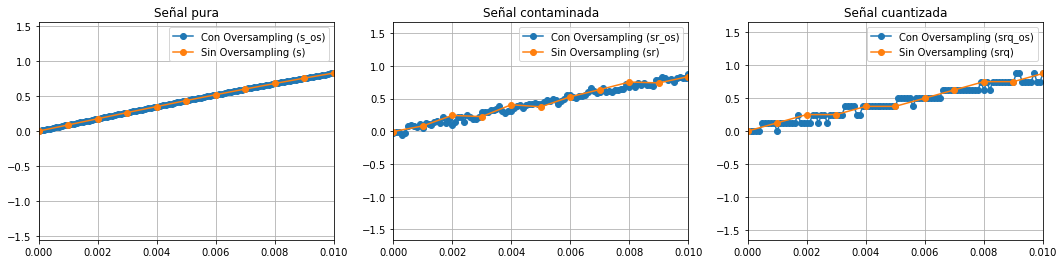

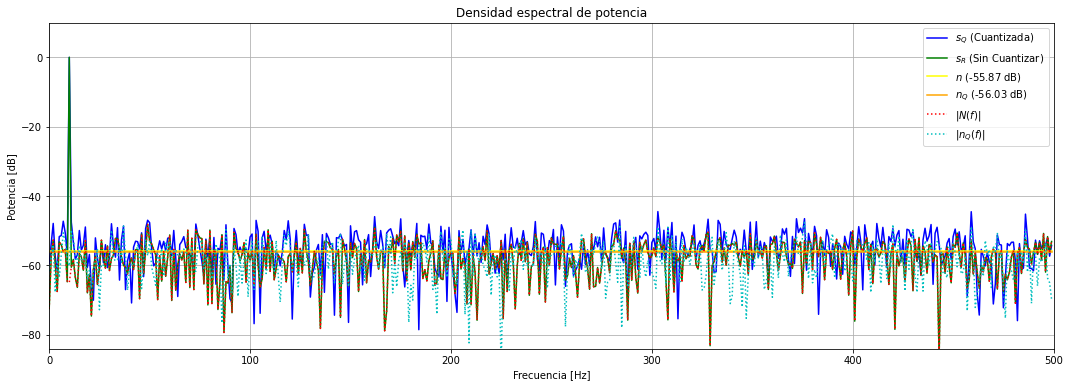

In [130]:
### Graficos temporales ###
plt.figure(figsize=(18, 4))

plt.subplot(1,3,1)
plt.plot(tt_os, s_os, 'o-', label='Con Oversampling (s_os)')
plt.plot(tt, s, 'o-', label='Sin Oversampling (s)')
plt.legend(); plt.grid();  plt.xlim(0, 0.01);plt.title("Señal pura")

plt.subplot(1,3,2)
plt.plot(tt_os, sr_os, 'o-', label='Con Oversampling (sr_os)')
plt.plot(tt, sr, 'o-', label='Sin Oversampling (sr)')
plt.legend(); plt.grid();  plt.xlim(0, 0.01);plt.title("Señal contaminada")

plt.subplot(1,3,3)
plt.plot(tt_os, srq_os, 'o-', label='Con Oversampling (srq_os)')
plt.plot(tt, srq, 'o-', label='Sin Oversampling (srq)')
plt.legend(); plt.grid();  plt.xlim(0, 0.01);plt.title("Señal cuantizada")
plt.show()

### Defino este grafico como una funcion ya que lo voy a estar repitiendo para cada caso de filtrado ###

def graficar_densidad_potencia(s, sr, srq, n, nq, fs, titulo='Densidad espectral de potencia'):
    """
    Grafica la densidad espectral de potencia (PSD) de una señal cuantizada, su versión sin cuantizar,
    el ruido analógico y el error de cuantización, incluyendo los pisos de ruido.

    Parámetros:
    - s: señal pura (sin ruido ni cuantización)
    - sr: señal con ruido
    - srq: señal cuantizada
    - n: ruido analógico
    - nq: error de cuantización (srq - sr)
    - fs: frecuencia de muestreo [Hz]
    - titulo: título del gráfico
    """
    N = len(s)
    ts = 1 / fs
    ff = np.fft.fftfreq(N, d=ts)

    # FFTs
    ft_S = np.fft.fft(s) / N
    ft_SR = np.fft.fft(sr) / N
    ft_Srq = np.fft.fft(srq) / N
    ft_N = np.fft.fft(n) / N
    ft_Nq = np.fft.fft(nq) / N

    # Potencias promedio
    P_s = np.mean(np.abs(ft_S)**2)
    P_n = np.mean(np.abs(ft_N)**2)
    P_nq = np.mean(np.abs(ft_Nq)**2)

    n_valor_db = 10 * np.log10(2 * P_n)
    nq_valor_db = 10 * np.log10(2 * P_nq)
    s_valor_db = 10 * np.log10(2 * P_s)

    # Recorto solo a las frecuencias positivas, no me interesa el eje negativo
    bfrec = (ff >= 0) & (ff <= fs / 2)
    ff_valid = ff[bfrec]

    # Curvas a graficar
    curvas = [
        ('$s_Q$ (Cuantizada)', ff_valid, 10 * np.log10(2 * np.abs(ft_Srq[bfrec])**2), 'b', '-'),
        ('$s_R$ (Sin Cuantizar)', ff_valid, 10 * np.log10(2 * np.abs(ft_SR[bfrec])**2), 'g', '-'),
        ('$n$ ({:.2f} dB)'.format(n_valor_db), ff_valid, [n_valor_db] * len(ff_valid), 'yellow', '-'),
        ('$n_Q$ ({:.2f} dB)'.format(nq_valor_db), ff_valid, [nq_valor_db] * len(ff_valid), 'orange', '-'),
        ('$|N(f)|$', ff_valid, 10 * np.log10(2 * np.abs(ft_N[bfrec])**2), 'r', ':'),
        ('$|n_Q(f)|$', ff_valid, 10 * np.log10(2 * np.abs(ft_Nq[bfrec])**2), 'c', ':'),
    ]

    # Graficar
    plt.figure(figsize=(18, 6))
    for titulo_curva, frec, pot, color, estilo in curvas:
        plt.plot(frec, pot, label=titulo_curva, color=color, linestyle=estilo)

    plt.title(titulo)
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Potencia [dB]')
    plt.grid(True)
    plt.xlim([0, fs / 2])
    plt.ylim((1.5 * np.min(10 * np.log10(2 * np.array([P_nq, P_n, P_s]))), 10))
    plt.legend()
    plt.show()

# Densidad de potencia de señal sin oversampling
graficar_densidad_potencia(s, sr, srq, n, nq, fs)

Notar especial atención a los piso de ruido de ambas señales, en particular al valor de la señal sin oversampling.


### Filtrado IIR

Planteamos una funcion para el diseño de un filtro IIR Butterworth.

In [131]:
def graficar_filtro_iir_(fc, orden, f_objetivo, atenuacion_rechazo_db, atenuacion_paso_db=-3, fs=1.0, ax=None):
    """
    Genera y grafica un filtro IIR Butterworth con parámetros dados.
    
    Parámetros:
    - fc: frecuencia de corte en Hz
    - orden: orden del filtro
    - f_objetivo: frecuencia objetivo donde se espera la atenuación de rechazo (Hz)
    - atenuacion_rechazo_db: dB deseados de rechazo a partir de f_objetivo (negativo)
    - atenuacion_paso_db: dB máximos permitidos en la banda de paso (default 0 dB)
    - fs: frecuencia de muestreo en Hz
    
    Retorna:
    - b, a: coeficientes del filtro IIR (numerador y denominador)
    """
    
    # Frecuencia de corte normalizada
    fc_norm = fc / (fs / 2)
    
    # Diseño del filtro
    b, a = sig.butter(orden, fc_norm, btype='low', analog=False)
    w, h = sig.freqz(b, a, worN=1024)
    f = w / np.pi
    h_db = 20 * np.log10(np.abs(h) + 1e-12)

    y_min, y_max = -100, 5

    if ax is None: # Util para poder usar el grafico en subplots
        ax = plt.gca()  # Usa el eje actual si no se pasa ninguno

    # Graficar en el eje proporcionado
    ax.plot(f, h_db, label='Respuesta en frecuencia', color='blue')
    ax.fill_between([0, fc / (fs / 2)], y_min, atenuacion_paso_db, color='gray', alpha=0.3, label='Zona de paso')
    ax.fill_between([f_objetivo / (fs / 2), 1], y_max, atenuacion_rechazo_db, color='gray', alpha=0.5, label='Zona de rechazo')
    ax.axhline(y=atenuacion_paso_db, color='green', linestyle='--', label=f'Límite paso: {atenuacion_paso_db} dB')
    ax.axhline(y=atenuacion_rechazo_db, color='red', linestyle='--', label=f'Rechazo en f={f_objetivo} Hz: {atenuacion_rechazo_db} dB')

    ax.set_title('Filtro IIR Butterworth (normalizado)')
    ax.set_xlabel('Frecuencia Normalizada (×π rad/sample)')
    ax.set_ylabel('Magnitud (dB)')
    ax.grid(True)
    ax.set_ylim([y_min, y_max])
    ax.set_xlim([0, 1])
    ax.legend()
    
    return b, a

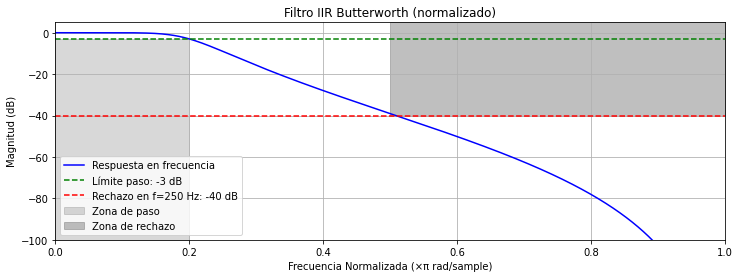

In [132]:
fc = 100         # Frecuencia de corte en Hz
orden = 4        # Orden del filtro
f_objetivo = 250 # Donde quiero que empiece a rechazar fuertemente
atenuacion_rechazo_db = -40
fs = 1000        # Frecuencia de muestreo
plt.figure(figsize=(12, 4))
b, a = graficar_filtro_iir_(fc, orden, f_objetivo, atenuacion_rechazo_db, fs=fs)
plt.show()

## Filtrado y downsampling de señal oversampleada

A continuacion vamos a realizar el correcto filtrado de la señal oversampleada, es decir, el filtro anti-alias, el cual respetara el limite de Nyquist donde:
$$ f_{corte} < f_s/2$$

En este caso tomaremos

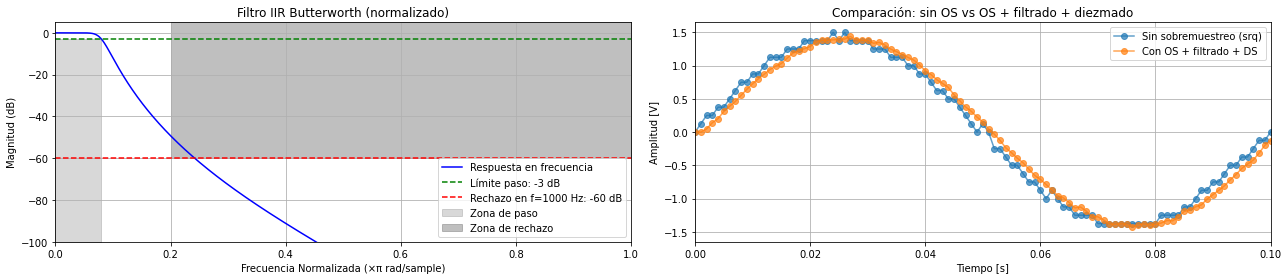

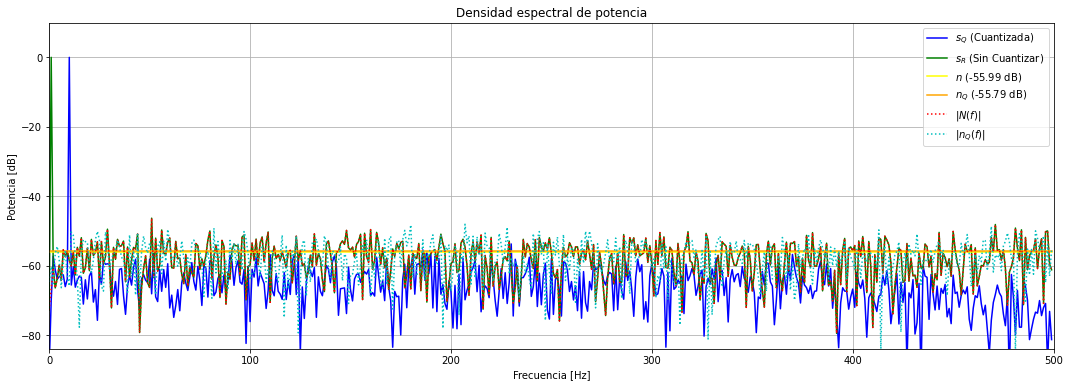

In [133]:
fcNyquist = fs/2
fc = fcNyquist * 0.8 # Frecuencia a partir de donde empiezo a rechazar
orden = 6
f_objetivo = 1000 # Frecuencia donde, idealmente, tendre la atenuacion de rechazo
atenuacion_rechazo_db = -60

fig, axs = plt.subplots(1, 2, figsize=(18, 4))

# Subplot 1
b, a = graficar_filtro_iir_(fc, orden, f_objetivo, atenuacion_rechazo_db, fs=fs_os, ax=axs[0])

# Filtrado
srq_os_filtrada = lfilter(b, a, srq_os)
# Downsampleo
srq_os_filtrada_ds = srq_os_filtrada[::ko]
tt_ds = tt_os[::ko]

# Subplot 2
axs[1].plot(tt, srq, 'o-', label='Sin sobremuestreo (srq)', alpha=0.7)
axs[1].plot(tt_ds, srq_os_filtrada_ds, 'o-', label='Con OS + filtrado + DS', alpha=0.7)
axs[1].set_title('Comparación: sin OS vs OS + filtrado + diezmado')
axs[1].set_xlabel('Tiempo [s]')
axs[1].set_ylabel('Amplitud [V]')
axs[1].legend()
axs[1].grid()
axs[1].set_xlim(0, 1/fo)

plt.tight_layout()
plt.show()

graficar_densidad_potencia(s, sr_os[:N], srq_os_filtrada_ds, n_os[:N], nq_os[:N], fs)

En el PSD se puede apreciar como a partir de los 400 Hz la señal empieza a ser atenuada, indicando el efecto del filtro pasa-bajos, cuyo efecto se ve reflejado en la grafica temporal

## Filtrado incorrecto

Ahora que se aprecio la ventaja del oversampling en conjunto con un filtro anti-alias, observaremos que sucede cuando no se aplica el filtro de manera correcta.

Recordemos, el caso ideal es el cual donde se respecta el limite de Nyquist:
$$ f_{corte} < f_s/2$$
En particular elegimos el caso $f_{corte} = f_s/2 * 0.8$

Ahora veremos 4 casos donde:
- $f_{corte} = f_{Nyquist}$: Nos plantamos exactamente en el limite de Nyquist
- $f_{corte} > f_{Nyquist}$: La señal se filtra por encima del limite de Nyquist (ligero efecto alias)
- $f_{corte} << f_{Nyquist}$: Se filtra por debajo del ancho de banda original, perdiendo informacion de la señal innecesariamente
- $f_{corte}$ no existe : La señal no se filtra (Maximo efecto alias)

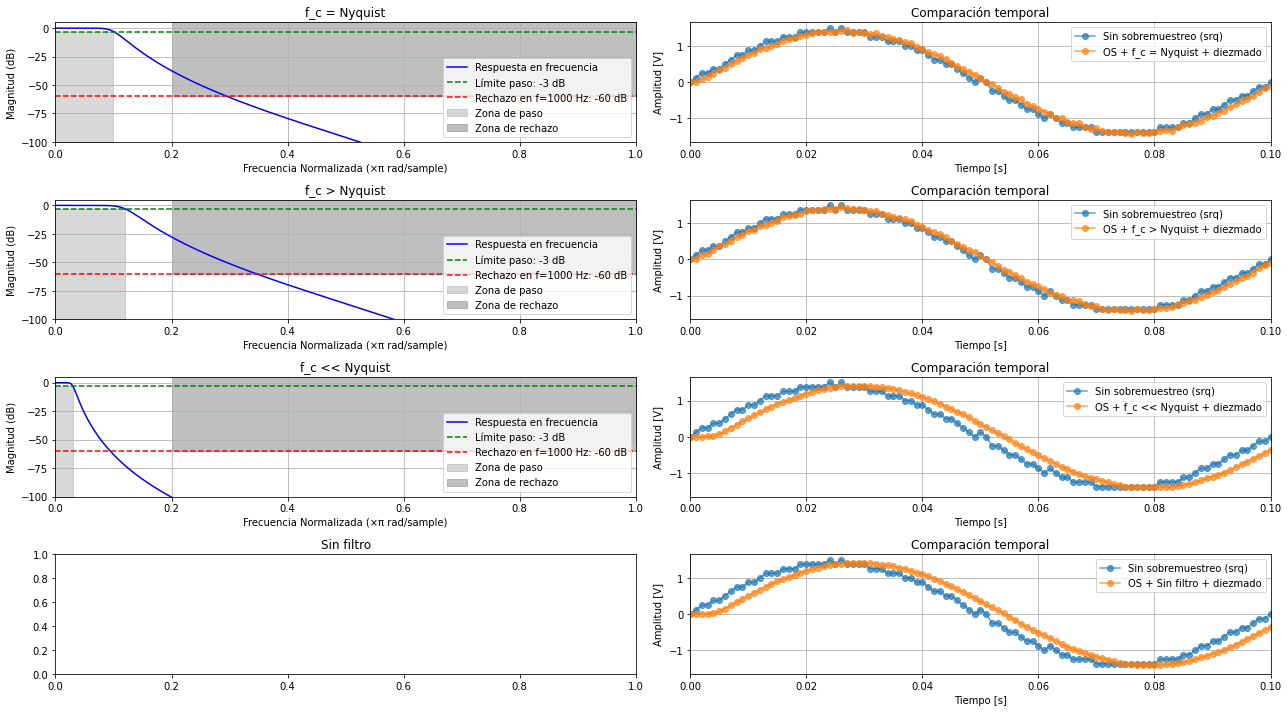

In [134]:
fc_1 = fcNyquist
fc_2 = fcNyquist * 1.2
fc_3 = fcNyquist * 0.3
orden = 6
f_objetivo = 1000 # Frecuencia donde, idealmente, tendre la atenuacion de rechazo
atenuacion_rechazo_db = -60

arr_titulos = ['f_c = Nyquist', 'f_c > Nyquist', 'f_c << Nyquist', 'Sin filtro']
arr_fcs = [fc_1, fc_2, fc_3]
arr_srq_os_filtrada_ds = []  # Lista para guardar cada señal filtrada y diezmada

fig, axs = plt.subplots(4, 2, figsize=(18, 10))
for i in range(4):
    if( i < 3):
        # Graficar respuesta del filtro
        b, a = graficar_filtro_iir_(
            fc=arr_fcs[i],
            orden=orden,
            f_objetivo=f_objetivo,
            atenuacion_rechazo_db=atenuacion_rechazo_db,
            fs=fs_os,
            ax=axs[i, 0]
        )
        axs[i, 0].set_title(arr_titulos[i])

        # Filtrado y diezmado
        srq_os_filtrada = lfilter(b, a, srq_os)
        srq_os_filtrada_ds = srq_os_filtrada[::ko]
        arr_srq_os_filtrada_ds.append(srq_os_filtrada_ds)
    else:
        axs[i, 0].set_title(arr_titulos[i])
        srq_os_diezmada = srq_os[::ko]
        arr_srq_os_filtrada_ds.append(srq_os_diezmada)

    # Gráfico temporal
    axs[i, 1].plot(tt, srq, 'o-', label='Sin sobremuestreo (srq)', alpha=0.7)
    axs[i, 1].plot(tt_ds, srq_os_filtrada_ds, 'o-', label=f'OS + {arr_titulos[i]} + diezmado', alpha=0.7)
    axs[i, 1].set_title('Comparación temporal')
    axs[i, 1].set_xlabel('Tiempo [s]')
    axs[i, 1].set_ylabel('Amplitud [V]')
    axs[i, 1].legend()
    axs[i, 1].grid()
    axs[i, 1].set_xlim(0, 1 / fo)

plt.tight_layout()
plt.show()

Analisis de las PSDs

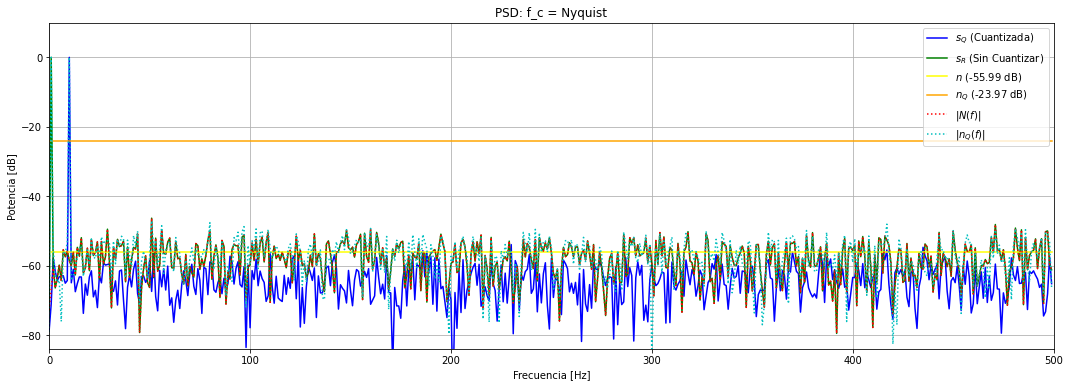

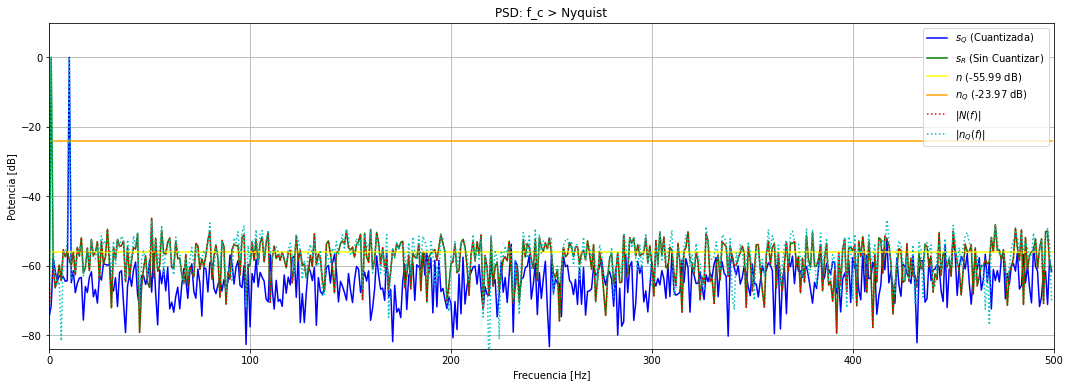

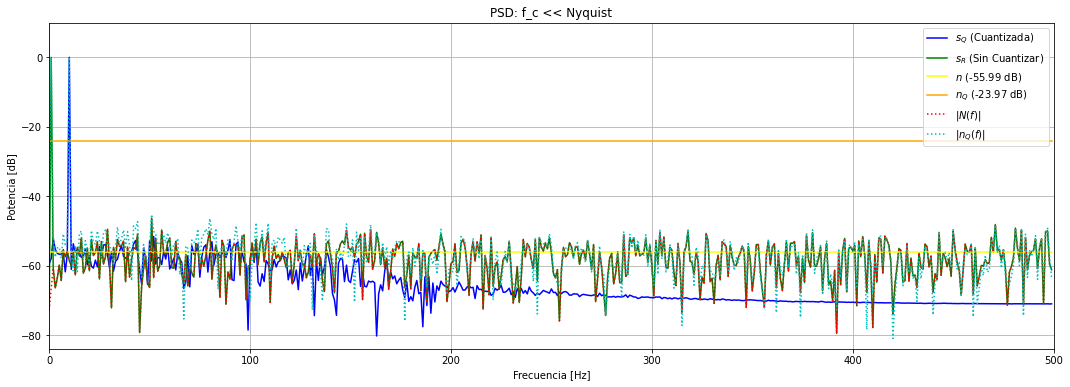

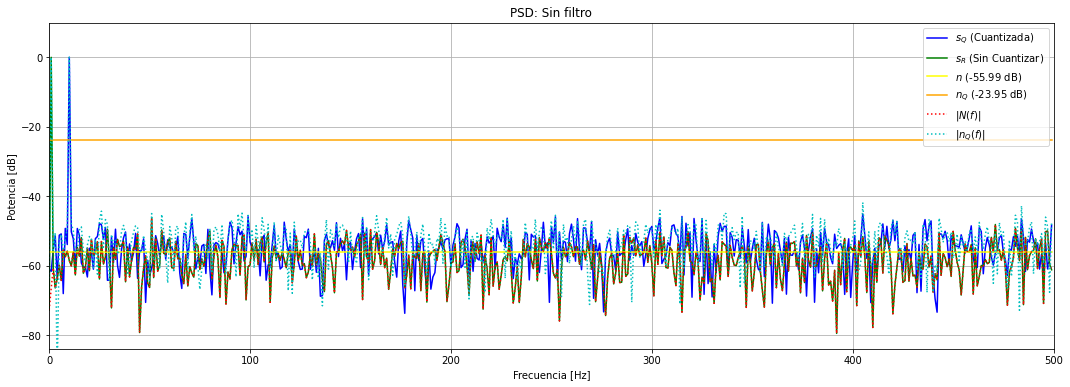

In [136]:
nq_os = arr_srq_os_filtrada_ds[0] - sr_os[:N]
graficar_densidad_potencia(s, sr_os[:N], arr_srq_os_filtrada_ds[0], n_os[:N], nq_os, fs, titulo=f'PSD: {arr_titulos[0]}')

nq_os = arr_srq_os_filtrada_ds[1] - sr_os[:N]
graficar_densidad_potencia(s, sr_os[:N], arr_srq_os_filtrada_ds[1], n_os[:N], nq_os, fs, titulo=f'PSD: {arr_titulos[1]}')

nq_os = arr_srq_os_filtrada_ds[2] - sr_os[:N]
graficar_densidad_potencia(s, sr_os[:N], arr_srq_os_filtrada_ds[2], n_os[:N], nq_os, fs, titulo=f'PSD: {arr_titulos[2]}')

nq_os = arr_srq_os_filtrada_ds[3] - sr_os[:N]
graficar_densidad_potencia(s, sr_os[:N], arr_srq_os_filtrada_ds[3], n_os[:N], nq_os, fs, titulo=f'PSD: {arr_titulos[3]}')

## Observaciones